In [ ]:
from typing import Optional, List, Tuple
import torch
import time
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm, colors
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
import matplotlib.patheffects as pe

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "STIXGeneral",
    "text.latex.preamble": r"\usepackage[utf8]{inputenc}\usepackage{amsmath}",
    "figure.figsize": [12, 4],  # ancho, Largo  
    "xtick.labelsize": 12,  # tamaño ticks en eje x
    "ytick.labelsize": 12   # tamaño ticks en eje y
})

import numpy as np
import pandas as pd
import numpy as np
import random


import os                          # Import operating system interface
import win32com.client as win32    # Import COM

from botorch.models import SingleTaskGP, ModelListGP
from botorch.optim import optimize_acqf
from botorch import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood

import torch.nn as nn
import torch.nn.functional as F
from botorch.models.transforms import Normalize, Standardize
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting
from botorch.acquisition.multi_objective.monte_carlo import qExpectedHypervolumeImprovement
from botorch.acquisition import UpperConfidenceBound, ExpectedImprovement
from botorch.sampling import SobolQMCNormalSampler
from botorch.utils.multi_objective.box_decompositions.non_dominated import (
    FastNondominatedPartitioning,
)


In [2]:
seed = 42
random.seed(seed) # random seed for Python's random module
np.random.seed(seed) # random seed for NumPy
torch.manual_seed(seed) # random seed for PyTorch

Generar puntos para entrenar el encoder y decoder

In [3]:
def data_encoder_generation(bounds, num_initial_points, categorical_variables = 4,seed = 42):
    """
    :parambounds: Bounds tensor for the variables.
    :param num_initial_points: Number of initial points to generate.
    :param satisfies_constraints: Function that checks if a point satisfies the constraints.
    :return: Results
    """
    # Deterministic behaviour
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    initial_points = []
    total_points = num_initial_points* categorical_variables
    while len(initial_points) < total_points:
        candidate_point = []
        for i in range(bounds.shape[1]): 
            value = torch.randint(bounds[0, i].to(torch.int).item(), bounds[1, i].to(torch.int).item() + 1, (1,)).item()
            candidate_point.append(value)      
  
        if satisfies_constraints_discrete(candidate_point):
            for k in range(categorical_variables):
                categorical_val = [k]
                discreteset_val = candidate_point
                initial_points.append( categorical_val + discreteset_val)
    return torch.tensor(initial_points, dtype=torch.float64)


def satisfies_constraints_discrete(x):
    Constraint_List = []
    Constraint_List.append(x[0]<x[1])  
    Feasibility = all(Constraint_List) == True   
    return Feasibility

bounds = torch.tensor([[1 , 20] ,
                       [60, 60]],dtype = torch.float64)
num_initial_points = 5000
initial_points = data_encoder_generation(bounds , num_initial_points=num_initial_points)
print('Number of points generated:', len(initial_points))
initial_points


Number of points generated: 20000


tensor([[ 0., 17., 28.],
        [ 1., 17., 28.],
        [ 2., 17., 28.],
        ...,
        [ 1.,  8., 55.],
        [ 2.,  8., 55.],
        [ 3.,  8., 55.]], dtype=torch.float64)

In [ ]:
columns_to_encode = initial_points
X_discrete_raw = columns_to_encode.clone() 
X_discrete_idx = X_discrete_raw.clone().detach()


VariationalAutoEncoder Class

In [8]:

class VariationalAutoencoder(nn.Module):
    def __init__(self, emb_dim=8,   latent_dim=8):
        super().__init__()
        self.emb_dim = emb_dim
        self.latent_dim = latent_dim
        # Embeddings for each discrete variable
        self.var1_emb = nn.Embedding(4, emb_dim)  
        self.var2_emb = nn.Embedding(60, emb_dim)
        self.var3_emb = nn.Embedding(41, emb_dim) 

        # Encoder y decoder
        self.encoder_fc = nn.Sequential(
            nn.Linear(3 * emb_dim, 16),
            nn.ReLU(),
            # nn.Linear(16, 8)
        )
        self.fc_mu = nn.Linear(16, latent_dim)
        self.fc_logvar = nn.Linear(16, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 3 * emb_dim)
        )

        # Individual decoders per variable
        self.var1_out = nn.Linear(emb_dim, 4)
        self.var2_out = nn.Linear(emb_dim, 60)
        self.var3_out = nn.Linear(emb_dim, 41)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def recover(self, z_space_predicted):

        y_decoded = self.decoder(z_space_predicted).squeeze(0)
        # Separate the decoder outputs for each variable
        f1_dec, f2_dec, st_dec = torch.chunk(y_decoded, 3, dim=1)
        f1_logits = self.var1_out(f1_dec)
        f2_logits = self.var2_out(f2_dec) 
        st_logits = self.var3_out(st_dec)

        # Apply softmax to obtain probabilities
        f1_probs = F.softmax(f1_logits, dim=1)
        f2_probs = F.softmax(f2_logits, dim=1)
        st_probs = F.softmax(st_logits, dim=1)

        # Adjust indexes
        f1_discrete = torch.argmax(f1_probs, dim=1)  # solvente
        f2_discrete = torch.argmax(f2_probs, dim=1) + 1  # alimentación
        # Mask for st_probs
        mask = torch.arange(41, device=st_probs.device).unsqueeze(0)
        invalid_mask = mask <= (f2_discrete.unsqueeze(1) - 20)
        st_probs[invalid_mask] = 0.0
        st_probs = st_probs / st_probs.sum(dim=1, keepdim=True)
        st_discrete = torch.argmax(st_probs, dim=1) + 20  

        return f1_discrete, f2_discrete, st_discrete

    def forward(self, x):
        # x: batch x 3 (enteros)
        solvent_type, f, nstages = x[:, 0], x[:, 1], x[:, 2]

        # Adjust indexes to 0-based
        solvent_idx = solvent_type 
        f1_idx = f - 1
        stage_idx = nstages - 20

        # Embeddings
        solvent_emb = self.var1_emb(solvent_idx)
        f_emb = self.var2_emb(f1_idx)
        st_emb = self.var3_emb(stage_idx)

        h = torch.cat([solvent_emb, f_emb, st_emb], dim=1)
        h_enc = self.encoder_fc(h)


        mu = self.fc_mu(h_enc)
        logvar = self.fc_logvar(h_enc)
        z = self.reparameterize(mu, logvar)
        
        h_dec = self.decoder(z)

        # Separate representation and decode each variable
        f1_dec, f2_dec, st_dec = torch.chunk(h_dec, 3, dim=1)

        f1_logits = self.var1_out(f1_dec)
        f2_logits = self.var2_out(f2_dec)
        st_logits = self.var3_out(st_dec)

        return f1_logits, f2_logits, st_logits , mu, logvar



Separate data into train and test, as they are randomly generated, shuffle is not necessary.

In [6]:
trainsize = int(len(initial_points)*.70)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = VariationalAutoencoder(emb_dim=8,   latent_dim= 8 ).to(device)
checkpoint = torch.load('VAE_LLExtraction.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

VariationalAutoencoder(
  (var1_emb): Embedding(4, 8)
  (var2_emb): Embedding(60, 8)
  (var3_emb): Embedding(41, 8)
  (encoder_fc): Sequential(
    (0): Linear(in_features=24, out_features=16, bias=True)
    (1): ReLU()
  )
  (fc_mu): Linear(in_features=16, out_features=8, bias=True)
  (fc_logvar): Linear(in_features=16, out_features=8, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=8, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=24, bias=True)
  )
  (var1_out): Linear(in_features=8, out_features=4, bias=True)
  (var2_out): Linear(in_features=8, out_features=60, bias=True)
  (var3_out): Linear(in_features=8, out_features=41, bias=True)
)

Test if initial data can be reconstructed with accuracy

In [ ]:

sample =  X_discrete_raw[0:trainsize].to(dtype=torch.long) 
with torch.no_grad():
    # Adjust indexes for embeddings
    f1_idx = sample[:, 0]
    f2_idx = sample[:, 1] - 1
    st_idx = sample[:, 2] - 20

    # Get embeddings
    f1_emb = model.var1_emb(f1_idx)
    f2_emb = model.var2_emb(f2_idx)
    st_emb = model.var3_emb(st_idx)

    # Concatenate embeddings and pass through the encoder
    h = torch.cat([f1_emb, f2_emb, st_emb], dim=1)
    h_enc = model.encoder_fc(h)
    mu = model.fc_mu(h_enc)
    logvar = model.fc_logvar(h_enc)
    z_train =  model.reparameterize(mu, logvar)

    # Pass z through the decoder
    y_decoded = model.decoder(z_train)

    # Separate the decoder outputs for each variable
    f1_dec, f2_dec, st_dec = torch.chunk(y_decoded, 3, dim=1)
    f1_logits = model.var1_out(f1_dec)
    f2_logits = model.var2_out(f2_dec) 
    st_logits = model.var3_out(st_dec)


    # Apply softmax to obtain probabilities
    f1_probs = F.softmax(f1_logits, dim=1)
    f2_probs = F.softmax(f2_logits, dim=1)
    st_probs = F.softmax(st_logits, dim=1)

    # Adjust indexes
    f1_discrete = torch.argmax(f1_probs, dim=1)  # solvente
    f2_discrete = torch.argmax(f2_probs, dim=1) + 1  # alimentación
    # Mask for st_probs
    mask = torch.arange(41, device=st_probs.device).unsqueeze(0)
    invalid_mask = mask <= (f2_discrete.unsqueeze(1) - 20)
    st_probs[invalid_mask] = 0.0
    st_probs = st_probs / st_probs.sum(dim=1, keepdim=True)
    st_discrete = torch.argmax(st_probs, dim=1) + 20  # etapas


# Combine discrete variables into a tensor
discrete_values = torch.cat([f1_discrete.unsqueeze(1), f2_discrete.unsqueeze(1), st_discrete.unsqueeze(1)], dim=1)

print("Discrete values recovered:", discrete_values)


Discrete values ​​recovered: tensor([[ 0, 17, 28],
        [ 1, 17, 28],
        [ 2, 17, 28],
        ...,
        [ 1, 20, 50],
        [ 2, 20, 50],
        [ 3, 20, 50]])


In [14]:
# bound
min_bounds, max_bounds = [] , []
for i in range(z_train.shape[1]):
    min_bounds.append(z_train[:,i].min().item())
    max_bounds.append(z_train[:,i].max().item())
print('min_bounds',min_bounds)
print('max_bounds',max_bounds)



min_bounds [-3.118105411529541, -2.6287574768066406, -2.9232852458953857, -3.1498303413391113, -1.9039850234985352, -3.511284112930298, -2.238119125366211, -3.0041580200195312]
max_bounds [2.6551554203033447, 3.2956795692443848, 2.957980155944824, 2.885223388671875, 2.8609373569488525, 4.32456111907959, 2.5893795490264893, 2.796095609664917]


### Begin B.O.

Generate points to evaluate with ASPEN, the bounds must correspond to the same as the autoencoder and decoder, otherwise the latent space can be projected with high uncertainty if these are recommended by B.O.

In [ ]:

def population_generation(bounds, var_types, num_initial_points,seed = 42):
    """
    :parambounds: Bounds tensor for the variables.
    :param num_initial_points: Number of initial points to generate.
    :param satisfies_constraints: Function that checks if a point satisfies the constraints.
    :return: Results
    """
    # Deterministic behaviour
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    initial_points_BO = []

    while len(initial_points_BO) < num_initial_points:
        candidate_point = []
        for i in range(len(var_types)): 
            if var_types[i] == 'real':
                value = torch.rand(1).item() * (bounds[1, i] - bounds[0, i]) + bounds[0, i]
            elif var_types[i] == 'int':
                value = torch.randint(bounds[0, i].to(torch.int).item(), bounds[1, i].to(torch.int).item() + 1, (1,)).item()
            candidate_point.append(value)
            
        #candidate_point = torch.tensor(candidate_point)
        if satisfies_constraints(candidate_point):
            initial_points_BO.append(candidate_point)
    return torch.tensor(initial_points_BO, dtype=torch.float64)

# Constrains
def satisfies_constraints(x):
    Constraint_List = []
    Constraint_List.append(x[3]<x[4]) 
    Feasibility = all(Constraint_List) == True   
    return Feasibility

# Manipulated variables  
#                       Re, S/F, SolventType, F, NT 
bounds = torch.tensor([[0.1, 1.5 , 0 , 1 , 20] ,
                       [3.0, 10.0, 3, 60, 60]],dtype = torch.float64)
var_types = ['real', 'real', 'int', 'int', 'int']

# Get initial points
num_initial_points = 50
initial_points_BO = population_generation(bounds, var_types , num_initial_points=num_initial_points)
print('Number of points generated:', len(initial_points_BO))
# initial_points_BO

Number of points generated: 50


In [16]:
# Discrete variables, format must be changed to long or int type
continuos_initial_points = initial_points_BO[:, 0:2].numpy()
discrete_initial_points = torch.tensor(np.array(initial_points_BO[:, 2:]),dtype=torch.long)

with torch.no_grad():
    # Adjust indexes for embeddings
    f1_idx = discrete_initial_points[:, 0] 
    f2_idx = discrete_initial_points[:, 1] - 1
    st_idx = discrete_initial_points[:, 2] - 20

    # Get embeddings
    f1_emb = model.var1_emb(f1_idx)
    f2_emb = model.var2_emb(f2_idx)
    st_emb = model.var3_emb(st_idx)

    # Concatenate embeddings and pass through the encoder
    h = torch.cat([f1_emb, f2_emb, st_emb], dim=1)
    h_enc = model.encoder_fc(h)

    mu = model.fc_mu(h_enc)
    logvar = model.fc_logvar(h_enc)
    z_new =  model.reparameterize(mu, logvar)
# Concatenate continuous variables with new latent space
converted_points = torch.tensor(np.hstack( (continuos_initial_points, z_new))  )

In [17]:

class AspenSimulation:
    
    def __init__(self, aspen_file_path1, aspen_file_path2):
        """
        Initializes the connection to ASPEN and sets the paths for variables and outputs.

        :param aspen_file_path: Path to the ASPEN file.
        :param variable_nodes: List of paths for variables in ASPEN.
        :param output_nodes: List of paths for outputs in ASPEN.
        """
        self.aspen_file_path1 = os.path.abspath(aspen_file_path1)
        self.aspen1 = None

        self.aspen_file_path2 = os.path.abspath(aspen_file_path2)
        self.aspen2 = None

    def connect(self):
        import win32com.client as win32 
        """Connect to ASPEN and load the first simulation"""
        self.aspen1 = win32.Dispatch("Apwn.Document") # .client.Dispatch("Apwn.Document")
        self.aspen1.InitFromFile(self.aspen_file_path1)
        self.aspen1.Visible  = False
        self.aspen1.SuppressDialogs = True
        time.sleep(3)
        self.aspen1.Engine.Run2()
        time.sleep(3)
        """Connect to ASPEN and load the second simulation"""
        self.aspen2 = win32.Dispatch("Apwn.Document") # .client.Dispatch("Apwn.Document")
        self.aspen2.InitFromFile(self.aspen_file_path2)
        self.aspen2.Visible  = False
        self.aspen2.SuppressDialogs = True
        time.sleep(1.1)
        self.aspen2.Engine.Run2()
        time.sleep(1.1)

    def Error_Run(self):
        return [0.0001, -1000] #  

    def Clean_Aspen(self):
        x = [85,2]
        #-----------------------------Column 1-----------------------------#
        N_C1 = r"\Data\Blocks\D1\Input\NSTAGE"
        FeedStage  = r"\Data\Blocks\D1\Input\FEED_STAGE\S1"  
        #Send to Aspen #
        self.aspen1.Tree.FindNode(N_C1).Value = x[0] 
        self.aspen1.Tree.FindNode(FeedStage).Value = x[1]   
        #Send to Aspen #
        self.aspen2.Tree.FindNode(N_C1).Value = x[0] 
        self.aspen2.Tree.FindNode(FeedStage).Value = x[1]   

    def Update_Aspen(self,x):
        #-----------------------------Column 1-----------------------------#
        N_C1 = r"\Data\Blocks\D1\Input\NSTAGE"
        RR_C1  = r"\Data\Blocks\D1\Input\BASIS_RR"
        solvent_flow_rate = r"\Data\Streams\SOLVENT\Input\TOTFLOW\MIXED"
        FeedStage  = r"\Data\Blocks\D1\Input\FEED_STAGE\S1"  
        #Send to Aspen #
        if x[2] == 0:
            self.aspen1.Tree.FindNode(N_C1).Value = x[4] 
            self.aspen1.Tree.FindNode(RR_C1).Value = x[0] 
            self.aspen1.Tree.FindNode(solvent_flow_rate).Value = x[1] 
            self.aspen1.Tree.FindNode(FeedStage).Value = x[3] 
        else:
            self.aspen2.Tree.FindNode(N_C1).Value = x[4] 
            self.aspen2.Tree.FindNode(RR_C1).Value = x[0] 
            self.aspen2.Tree.FindNode(solvent_flow_rate).Value = x[1] 
            self.aspen2.Tree.FindNode(FeedStage).Value = x[3] 
            if x[2] == 1:
                self.aspen2.Tree.FindNode(r"\Data\Streams\SOLVENT\Input\FLOW\MIXED\1-DEC-01").Value = 1
                self.aspen2.Tree.FindNode(r"\Data\Streams\SOLVENT\Input\FLOW\MIXED\1-OCT-01").Value = 0
                self.aspen2.Tree.FindNode(r"\Data\Streams\SOLVENT\Input\FLOW\MIXED\N-BUT-01").Value = 0
            elif x[2] == 2:
                self.aspen2.Tree.FindNode(r"\Data\Streams\SOLVENT\Input\FLOW\MIXED\1-DEC-01").Value = 0
                self.aspen2.Tree.FindNode(r"\Data\Streams\SOLVENT\Input\FLOW\MIXED\1-OCT-01").Value = 1
                self.aspen2.Tree.FindNode(r"\Data\Streams\SOLVENT\Input\FLOW\MIXED\N-BUT-01").Value = 0
            elif x[2] == 3:
                self.aspen2.Tree.FindNode(r"\Data\Streams\SOLVENT\Input\FLOW\MIXED\1-DEC-01").Value = 0
                self.aspen2.Tree.FindNode(r"\Data\Streams\SOLVENT\Input\FLOW\MIXED\1-OCT-01").Value = 0
                self.aspen2.Tree.FindNode(r"\Data\Streams\SOLVENT\Input\FLOW\MIXED\N-BUT-01").Value = 1

    def Feasibily_Check(self,x):
        Constraint_List = []
        Constraint_List.append(x[3]<x[4])
        Feasibility = all(Constraint_List) == True 
        return Feasibility

    def run_simulation(self, variables):
        """
        Runs the simulation in ASPEN with the values ​​of the provided variables.
        :param variables: List or array of values ​​for the variables.
        :return: Array of output results.
        """
        self.aspen1.Reinit()
        self.aspen2.Reinit()
        # Before running Aspen evaluate if the point is feasible
        if self.Feasibily_Check(variables) == False: 
            print("Unfeasible point tested, point is penalized")
            results =  self.Error_Run() 
            return results 
        Run_Status_Dir = r"\Data\Results Summary\Run-Status\Output\UOSSTAT2"
        results = []  # List to save ressult
        if variables[2] == 0:  # Solvent one is tested (first simulation)
            if self.aspen1 is None:
                raise RuntimeError("ASPEN is not connected. Call connect() before running a simulation.")
            
            # Clean Aspen with default values
            self.Clean_Aspen()

            # Assigns the values ​​of the variables in ASPEN
            self.Update_Aspen(variables)

            # Run the simulation
            self.aspen1.Engine.Run2()

            if self.aspen1.Tree.FindNode(Run_Status_Dir) == None:
                results =  self.Error_Run()  
            else:
                Run_Status = self.aspen1.Tree.FindNode(Run_Status_Dir).Value
                if Run_Status == 9 or Run_Status == 10:
                    results =  self.Error_Run() 
                    self.aspen1.Reinit()
                else:
                    # PUREZa
                    pureza = self.aspen1.Tree.FindNode(r"\Data\Streams\PRODUCT\Output\MOLEFRAC\MIXED\CAPRYC").Value
                    results.append(pureza)


                    # REBOILER  B1 #
                    REB_DUTY_D1 = r"\Data\Blocks\D1\Output\REB_DUTY"
                    ReboilerDuty = self.aspen1.Tree.FindNode(REB_DUTY_D1).Value*0.0041868    #cal/sec to kW
                    results.append(-1*ReboilerDuty)
                    self.aspen1.Reinit()
        else: # Other solvent
            if self.aspen2 is None:
                raise RuntimeError("ASPEN is not connected. Call connect() before running a simulation.")
            # Clean Aspen 
            self.Clean_Aspen()
            # Update Aspen
            self.Update_Aspen(variables)
            # Run simulation
            self.aspen2.Engine.Run2()

            if self.aspen2.Tree.FindNode(Run_Status_Dir) == None:
                results =  self.Error_Run()  
            else:
                Run_Status = self.aspen2.Tree.FindNode(Run_Status_Dir).Value
                if Run_Status == 9 or Run_Status == 10:
                    results =  self.Error_Run() 
                    self.aspen2.Reinit()
                else:
                    # PUREZa
                    pureza = self.aspen2.Tree.FindNode(r"\Data\Streams\PRODUCT\Output\MOLEFRAC\MIXED\CAPRYC").Value
                    results.append(pureza)

                    # REBOILER  B1 #
                    REB_DUTY_D1 = r"\Data\Blocks\D1\Output\REB_DUTY"
                    ReboilerDuty = self.aspen2.Tree.FindNode(REB_DUTY_D1).Value*0.0041868    #cal/sec to kW
                    results.append(-1*ReboilerDuty)
                    self.aspen2.Reinit()

        return results

    def close(self):
        """Close the connection to ASPEN."""
        if self.aspen1 is not None:
            self.aspen1.Close()
            self.aspen1 = None
        if self.aspen2 is not None:
            self.aspen2.Close()
            self.aspen2 = None


In [19]:
Application = AspenSimulation(aspen_file_path1= "CaprylicAcid_ST1.bkp" , aspen_file_path2 = "CaprylicAcid_ST2.bkp" )
Application.connect()
initial_evals = torch.tensor(np.array([Application.run_simulation(point) for point in initial_points_BO]), dtype=torch.float64)
mask = initial_evals[:, 1] > -999
initial_evals = initial_evals[mask]
initial_points_BO = initial_points_BO[mask]
converted_points = converted_points[mask]
print('initial evaluations' , initial_evals.shape)
print('Max function value (reboiler):', initial_evals[:,1].max().item())
print('Min function value (reboiler):', initial_evals[:,1].min().item())
print('Max function value (composition):', initial_evals[:,0].max().item())
print('Min function value (composition):', initial_evals[:,0].min().item())
Application.close()

initial evaluations torch.Size([49, 2])
Max function value (reboiler): -47.188962251999996
Min function value (reboiler): -672.9729096024
Max function value (composition): 0.952380952
Min function value (composition): 0.0360183142


Multiobjective class

In [ ]:

class MultiObjectiveBayesianOpt:
    """
    Multi-objective Bayesian Optimization over a mixed design space (x + latent z).

    This class automates:
    - Independent GP training for each objective
    - Pareto front identification (minimization convention handled internally)
    - Point selection based on predictive uncertainty or acquisition functions
    - Iterative data augmentation with external evaluator (e.g., Aspen)

    Parameters
    ----------
        X_init : torch.Tensor       Initial design points of shape (n0, d), where d = 2 + latent_dim (the first 2 are x, the rest are z).
        Y_init : torch.Tensor       Initial objective values ​​of shape (n0, m), with m objectives.
        bounds : torch.Tensor       Tensor of shape (2, d) with lower/upper bounds for each variable (x and z).
        model_enddec : object       Model with `recover(z_batch)` method → ​​returns discrete variables decoded from z.
        obj_names : List[str]       Names of the objective functions .
        latent_dim : int            Dimension of the latent space .
        n_evals : int               Total number of desired objective evaluations (including initial ones).
        method: str                 Selection method: 'std' (Pareto uncertainty), 'UCB', 'EI', or 'qEHV' (EHVI).
        Aspen_Application: object   Handler with `connect()`, `run_simulation(point)`, `close()` methods.

    Attributes
    ----------
        Aspen_Application : object   Connection to the external evaluator (e.g., Aspen).
        n_evals : int                Total evaluation budget.
        X_init : torch.Tensor        Copy of the initial points.
        Y_init : torch.Tensor        Copy of the initial objectives.
        obj_names : List[str]        Objective names.
        bounds : torch.Tensor        Bounds (2, d).
        model_enddec : object        Decoding model z → discrete variables.
        latent_dim : int             Latent dimension.
        method: str                  Selection strategy.
        all_points: torch.Tenso      Cumulative dataset X (n, d).
        all_objectives: torch.Tensor        Cumulative dataset Y (n, m).
        gp_models: List[SingleTaskGP]       GP models (one per objective).
        mlls: List[ExactMarginalLogLikelihood]  MLL losses for GP fitting.
        final_points: Optional[torch.Tensor]    Last candidate cloud evaluated by GPs/acquisition (n_grid, d).
        pareto_front_list: List[pd.DataFrame]   Front tracking history (means and stds) by iterations (for export).
        data_front_list: List[pd.DataFrame]     History of proposed candidates by iterations (for export).
        pareto_front : np.ndarray               Final Pareto front (using internal minimization convention).
        pareto_indices : np.ndarray             Indices of the non-dominated points within `final_points`.
        pareto_std : np.ndarray                 Standard deviations associated with the front end.
        latent_space_BO : List[torch.Tensor]    List of tensors (1, k, latent_dim) with z proposed in iterations.
        tracking_OF1 : List[float]        Best observed value for objective 2 (for consistency with the original code).
        tracking_OF2 : List[float]        Best observed value for objective 1 (for consistency with the original code).
    """

    def __init__(self, X_init, Y_init, bounds, model_enddec,
                 obj_names, latent_dim, n_evals, method, Aspen_Application):

        # Initialize Aspen
        self.Aspen_Application = Aspen_Application
        self.Aspen_Application.connect()

        # Additional variables 
        self.n_evals = n_evals
        self.X_init = X_init
        self.all_points = X_init
        self.Y_init = Y_init
        self.all_objectives = Y_init

        self.obj_names = obj_names
        self.bounds = bounds
        self.model_enddec = model_enddec
        self.latent_dim = latent_dim

        # Training data
        self.method = method

        # Pareton front 
        self.pareto_front_list = []
        self.data_front_list = []
        self.final_points: Optional[torch.Tensor] = None

        # Inicializaciones del ciclo
        self.gp_models: List[SingleTaskGP] = []
        self.mlls: List[ExactMarginalLogLikelihood] = []

        # Resultados de Pareto actuales
        self.pareto_front: Optional[np.ndarray] = None
        self.pareto_indices: Optional[np.ndarray] = None
        self.pareto_std: Optional[np.ndarray] = None

        # Tracking iterativo
        self.latent_space_BO: List[torch.Tensor] = []
        self.tracking_OF1: List[float] = []
        self.tracking_OF2: List[float] = []

    def train_gpr_model(self, X: torch.Tensor, Y: torch.Tensor) -> None:
        """Train independent Gaussian Process models for each objective function."""
        self.gp_models = []
        for i in range(Y.shape[1]):
            gp = SingleTaskGP(X, Y[:,i].unsqueeze(1) , 
                                input_transform=Normalize(d=10),
                                outcome_transform=Standardize(m=1))
            self.gp_models.append(gp)
        self.mlls = [ExactMarginalLogLikelihood(m.likelihood, m) for m in self.gp_models]
        for mll in self.mlls:
            fit_gpytorch_mll(mll)

    def prediction_grid_std(self, acqfs: List, batch_size: int = 100,
                             n_samples: int = 5000, ktop: int = 10) -> torch.Tensor:
        """
        Evalute the aqcs with the bounds.
        Return: topk_candidates
        """
        n_dims = self.bounds.shape[1] 

        # Sample uniform random points in each dimension of the bounds
        random_samples = torch.rand(n_samples, n_dims, dtype=torch.float64)
        lower_bounds = self.bounds[0]
        upper_bounds = self.bounds[1]
        scaled_samples = lower_bounds + (upper_bounds - lower_bounds) * random_samples
        self.final_points =  scaled_samples 
        final_points_batched = self.final_points

        batch_size = 100
        acq_values_list = []
        all_indices = []
        offset = 0
        with torch.no_grad():
            for acqf in acqfs:
                local_acq_values  = []
                for i in range(0, final_points_batched.shape[0], batch_size):
                    batch = final_points_batched[i:i + batch_size]  # slice batch
                    acq_vals = acqf(batch.unsqueeze(1))  # acqf(batch)
                    local_acq_values.append(acq_vals.squeeze(-1)) #local_acq_values.append(acq_vals)

                # Save all values for each aqf
                local_acq_values = torch.cat(local_acq_values, dim=0)# Actualizar el ofset para mantener indices diferente
                # Save values ​​in a global list
                acq_values_list.append(local_acq_values)


                # Save all indexes for each aqf
                indices = torch.arange(final_points_batched.shape[0], dtype=torch.long) + offset
                all_indices.append( indices)
                # Update offset to keep indexes different
                offset += final_points_batched.shape[0]
        
        acq_values = torch.cat(acq_values_list, dim=0).squeeze(-1)
        final_points_expanded = final_points_batched.repeat(len(acqfs), 1)  # (A*n_samples, d)

        k = int(min(ktop, acq_values.numel()))
        topk_vals, topk_indices = torch.topk(acq_values, k=k)
        topk_candidates = final_points_expanded[topk_indices]
        return topk_candidates
        
    def prediction_grid_ehvi(self, acqf, bounds: torch.Tensor, 
                             ktop: int = 10, n_samples: int = 5000,
                             batch_size: int = 100) -> torch.Tensor:
        """
        Evaluates EHVI on a grid of points and returns the best ktop.
        """
        n_dims = bounds.shape[1]

        # Generate uniform samples
        random_samples = torch.rand(n_samples, n_dims, dtype=torch.float64)
        lower_bounds = bounds[0]
        upper_bounds = bounds[1]
        scaled_samples = lower_bounds + (upper_bounds - lower_bounds) * random_samples

        scaled_samples = scaled_samples.double()
        acq_values = []

        with torch.no_grad():
            for i in range(0, n_samples, batch_size):
                batch = scaled_samples[i:i + batch_size]
                vals = acqf(batch.unsqueeze(1))  # EHVI requiere q-batches, así que q=1
                acq_values.append(vals.squeeze(-1))

        acq_values = torch.cat(acq_values, dim=0)
        topk_vals, topk_indices = torch.topk(acq_values, k=ktop)
        topk_candidates = scaled_samples[topk_indices]
        return topk_candidates

    def evaluate_gps_withoutMC(self, n_samples: int = 5000) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Evalute the gps with the bounds.
        Return: 
            all_means: predictions
            all_std: standart deviation for each point
        """
        n_dims = bounds.shape[1]  

        # Sample uniform random points in each dimension of the bounds
        random_samples = torch.rand(n_samples, n_dims, dtype=torch.float64)
        lower_bounds = bounds[0]
        upper_bounds = bounds[1]
        scaled_samples = lower_bounds + (upper_bounds - lower_bounds) * random_samples
        self.final_points =  scaled_samples 
        final_points_batched = self.final_points 

        # Generate random indices
        batch_size = 100
        points_gps = []
        points_std = []
        with torch.no_grad():
            for gp in self.gp_models:
                local_mean_values  = []
                local_std_values = []
                for i in range(0, final_points_batched.shape[0], batch_size):
                    batch = final_points_batched[i:i + batch_size]  # slice batch
                    prediction = gp.posterior(batch) #batch.unsqueeze(-1))
                    local_mean_values.append(prediction.mean)
                    local_std_values.append(prediction.stddev.unsqueeze(1))
                # Save values ​​for each bump for each gp
                local_mean_values = torch.cat(local_mean_values, dim=0)
                local_std_values = torch.cat(local_std_values, dim=0)
                # Save the values ​​in a global list
                points_gps.append(local_mean_values)
                points_std.append(local_std_values)
        all_means = torch.cat(points_gps, dim=1).squeeze(-1)
        all_std = torch.cat(points_std, dim=1).squeeze(-1)                  
        return all_means , all_std

    def find_pareto_front(self, all_means: torch.Tensor,
                           all_stdvs: torch.Tensor,  maximize=True) -> None:
        """
        Identify the Pareto front considering maximization/minimization objectives.

        Args:
            maximize (list of bool, optional): List indicating whether each objective
                                              should be maximized (True) or minimized (False).
                                              If None, assumes all objectives should be maximized.
        """                                   
        self.pareto_front = []
        self.pareto_std = []
        self.pareto_indices = []

        # Convertir tensor a numpy
        F_space = all_means.cpu().numpy().astype(np.float32)

        stds = all_stdvs.cpu().numpy().astype(np.float32)

        F_space[:, 1] = -F_space[:, 1] # Cambiar la carga termica a positiva
        F_space[:, 0] = -F_space[:, 0] # Cambiar la composicion a negativa 

        # Do non-dominated sorting
        nds = NonDominatedSorting()          
        chunk_size = 100
        num_chunks = int(np.ceil(F_space.shape[0] / chunk_size))
        
        # Initialize with the first block
        current_front = F_space[:chunk_size]
        current_stds = stds[:chunk_size]
        current_indices = np.arange(chunk_size)

        #  Save first optimal points, std and indexes.
        front_indices  = nds.do(current_front, only_non_dominated_front=True)
        #  Get the best unmastered designs
        current_front = current_front[front_indices]
        current_stds = current_stds[front_indices]
        current_indices = current_indices[front_indices]

        list_indices = []
        for i in range(1, num_chunks):
            start = i * chunk_size
            end = min((i + 1) * chunk_size, F_space.shape[0])
            chunk = F_space[start:end]
            chunk_stds = stds[start:end]
            chunk_indices = np.arange(start, end)
            # Combines with previous discrete points
            combined = np.vstack([current_front, chunk])
            combined_stds = np.vstack([current_stds, chunk_stds])
            combined_indices = np.concatenate([current_indices, chunk_indices])
            # Go back to look for unmastered points
            reduced_indices = nds.do(combined, only_non_dominated_front=True)
            
            # Update front
            current_front = combined[reduced_indices]
            current_stds = combined_stds[reduced_indices]
            current_indices = combined_indices[reduced_indices]
       
        self.pareto_front = current_front
        self.pareto_indices = current_indices
        self.pareto_std = current_stds

    def select_uncertain_points(self, evaluation_points: torch.Tensor,
                                 n_points: int = 50) -> torch.Tensor:
        """
        Select points from Pareto front with highest uncertainty.

        Args:
            n_points (int, optional): Number of points to select (default=2)

        Returns:
            np.array: Selected points in scaled coordinates
        """

        # Use uncertainty from first objective for selection
        uncertainty = np.linalg.norm(np.vstack([self.pareto_std[:,i] for i in range(self.pareto_std.shape[1])]).T, axis=1) 
        # Ensure we don't request more points than available
        n_points = min(n_points, len(self.pareto_indices))

        # Select points with highest uncertainty
        top_indices = np.argsort(-uncertainty)[:n_points]
        selected_indices = self.pareto_indices[top_indices]
        return evaluation_points[selected_indices]

    def converted_candidates(self):
        # Pass z through the decoder
        z_space_predicted = torch.tensor([self.all_points[:, -self.latent_dim:].numpy()] , dtype=torch.float32)
        f1_discrete, f2_discrete, st_discrete = self.model_enddec.recover(z_space_predicted)
        return torch.cat((self.all_points[:,:2], f1_discrete.unsqueeze(1), f2_discrete.unsqueeze(1), st_discrete.unsqueeze(1)), dim=1).numpy()

    def run_optimization(self, maximize=None, n_points_per_iter: int = 2, 
                         objective_function=None) -> None:
        """
        Run the complete optimization process for all iterations.

        Args:
            maximize (list of bool): List indicating whether each objective should be maximized
            n_points_per_iter (int): Number of points to select in each iteration
            objective_function (callable): Function to calculate Y values from X (optional)
                                          If provided, will be used to calculate new Y values
        """
        
        self.latent_space_BO = []
        self.tracking_OF1 = []
        self.tracking_OF2 = []
        self.utopia_distance = []
        self.all_points, self.all_objectives = self.X_init, self.Y_init
        number_eval = self.X_init.shape[0]

        iteration = 0
        print('Start optimization process')
        while number_eval < self.n_evals:
            if self.method == 'std':
                self.train_gpr_model(self.all_points, self.all_objectives)
                all_means , all_std = self.evaluate_gps_withoutMC(n_samples = 10000)
                self.find_pareto_front(all_means, all_std, maximize=None)
                best_candidates = self.select_uncertain_points( self.final_points ) 
                optimal_candidates = best_candidates

                # Pass z through the decoder
                z_space_predicted = torch.tensor(optimal_candidates[:, 2:].numpy(), dtype=torch.float32).unsqueeze(0)
                self.latent_space_BO.append(z_space_predicted)

                f1_discrete, f2_discrete, st_discrete = self.model_enddec.recover(z_space_predicted)

                new_candidates  = torch.cat((optimal_candidates[:,0:2], f1_discrete.unsqueeze(1), 
                                            f2_discrete.unsqueeze(1), st_discrete.unsqueeze(1)), dim=1).numpy()
                # Robustly evaluate Aspen
                new_candidates = np.asarray(new_candidates)
                new_candidates = np.atleast_2d(new_candidates) 

                results  = torch.tensor(np.array([self.Aspen_Application.run_simulation(point) for point in new_candidates]), dtype=torch.float64)
                new_eval_np = np.asarray(results, dtype=float)
                new_eval_np = np.atleast_2d(new_eval_np)  

                if (iteration % 10 == 0) :
                    pf_array = torch.concatenate((all_means, all_std), dim=1).numpy()
                    df1 = pd.DataFrame(pf_array, columns=["mean1","mean2","std1","std2"])
                    df1["iteration"] = iteration + 1
                            
                    self.pareto_front_list.append(df1)
                    data_array = optimal_candidates # torch.concatenate((optimal_candidates, z_space_predicted), dim = 1).numpy()
                    df2 = pd.DataFrame(data_array, columns=["x1","x2","z1", "z2","z3","z4","z5","z6","z7","z8"])
                    df2["iteration"] = iteration + 1
                    self.data_front_list.append(df2)

                if new_eval_np.shape[1] < 2:
                    print(f"Resampling…")
                    iteration += 1
                    continue
                
                # --- Feasibility mask ---
                mask_np = new_eval_np[:, 1] > -999
                if not np.any(mask_np):
                    print("All the proposed points were unfeasible. Re-sampling with more points…")
                    iteration += 1
                    continue

                new_eval_np = new_eval_np[mask_np]
                new_candidates = new_candidates[mask_np]
                mask_torch = torch.from_numpy(mask_np)
                optimal_candidates = optimal_candidates[mask_torch]
                
                # Convert evaluations to torch if you need them as tensors
                new_eval = torch.as_tensor(new_eval_np, dtype=torch.float64)

                # Update data collected by the GP
                self.all_points = torch.cat([self.all_points, optimal_candidates ], dim = 0 )  
                self.all_objectives = torch.cat([self.all_objectives, new_eval], dim = 0  ) 

                self.tracking_OF1.append(self.all_objectives[:,1].max().item())
                self.tracking_OF2.append(self.all_objectives[:,0].max().item())

                number_eval = self.all_points.shape[0]
                iteration += 1 
                print('number of functions evaluations:', number_eval)
            
            elif self.method == 'UCB':
                self.train_gpr_model(self.all_points, self.all_objectives)
                all_means , all_std = self.evaluate_gps_withoutMC(n_samples = 10000)

                UpperConfidenceBound_acquisitions = [UpperConfidenceBound(gp, beta=0.1) for gp in self.gp_models]
                best_candidates = self.prediction_grid_std(UpperConfidenceBound_acquisitions)
                optimal_candidates = best_candidates

                # Pass z through the decoder
                z_space_predicted = torch.tensor(optimal_candidates[:, 2:].numpy(), dtype=torch.float32).unsqueeze(0)
                self.latent_space_BO.append(z_space_predicted)

                f1_discrete, f2_discrete, st_discrete = self.model_enddec.recover(z_space_predicted)

                new_candidates  = torch.cat((optimal_candidates[:,0:2], f1_discrete.unsqueeze(1), 
                                            f2_discrete.unsqueeze(1), st_discrete.unsqueeze(1)), dim=1).numpy()
                new_candidates = np.asarray(new_candidates)
                new_candidates = np.atleast_2d(new_candidates) 

                results  = torch.tensor(np.array([self.Aspen_Application.run_simulation(point) for point in new_candidates]), dtype=torch.float64)
                new_eval_np = np.asarray(results, dtype=float)
                new_eval_np = np.atleast_2d(new_eval_np) 

                if (iteration % 10 == 0) :
                    pf_array = torch.concatenate((all_means, all_std), dim=1).numpy()
                    df1 = pd.DataFrame(pf_array, columns=["mean1","mean2","std1","std2"])
                    df1["iteration"] = iteration + 1
                            
                    self.pareto_front_list.append(df1)
                    data_array = optimal_candidates # torch.concatenate((optimal_candidates, z_space_predicted), dim = 1).numpy()
                    df2 = pd.DataFrame(data_array, columns=["x1","x2","z1", "z2","z3","z4","z5","z6","z7","z8"])
                    df2["iteration"] = iteration + 1
                    self.data_front_list.append(df2)

                if new_eval_np.shape[1] < 2:
                    print(f"Resampling…")
                    iteration += 1
                    continue
                
                # --- Feasibility mask ---
                mask_np = new_eval_np[:, 1] > -999
                if not np.any(mask_np):
                    print("All the proposed points were unfeasible. Re-sampling with more points…")
                    iteration += 1
                    continue
                
                new_eval_np = new_eval_np[mask_np]
                new_candidates = new_candidates[mask_np]
                mask_torch = torch.from_numpy(mask_np)
                optimal_candidates = optimal_candidates[mask_torch]

                # Convert evaluations to torch if you need them as tensors
                new_eval = torch.as_tensor(new_eval_np, dtype=torch.float64)

                # Update data collected by the GP
                self.all_points = torch.cat([self.all_points, optimal_candidates ], dim = 0 )  
                self.all_objectives = torch.cat([self.all_objectives, new_eval], dim = 0  ) 

                self.tracking_OF1.append(self.all_objectives[:,1].max().item())
                self.tracking_OF2.append(self.all_objectives[:,0].max().item())

                number_eval = self.all_points.shape[0]
                iteration += 1 
                print('number of functions evaluations:', number_eval)

            elif self.method == 'EI':
                self.train_gpr_model(self.all_points, self.all_objectives)
                all_means , all_std = self.evaluate_gps_withoutMC(n_samples = 10000)
                ExpectedImprovement_acquisitions  = [ExpectedImprovement(gp,best_f = self.all_objectives[:,i].max().item()  ) for i, gp in enumerate(self.gp_models)]
                best_candidates = self.prediction_grid_std(ExpectedImprovement_acquisitions)
                optimal_candidates = best_candidates

                # Pass z through the decoder
                z_space_predicted = torch.tensor(optimal_candidates[:, 2:].numpy(), dtype=torch.float32).unsqueeze(0)
                self.latent_space_BO.append(z_space_predicted)

                f1_discrete, f2_discrete, st_discrete = self.model_enddec.recover(z_space_predicted)

                new_candidates  = torch.cat((optimal_candidates[:,0:2], f1_discrete.unsqueeze(1), 
                                            f2_discrete.unsqueeze(1), st_discrete.unsqueeze(1)), dim=1).numpy()
                new_candidates = np.asarray(new_candidates)
                new_candidates = np.atleast_2d(new_candidates) 

                results  = torch.tensor(np.array([self.Aspen_Application.run_simulation(point) for point in new_candidates]), dtype=torch.float64)
                new_eval_np = np.asarray(results, dtype=float)
                new_eval_np = np.atleast_2d(new_eval_np) 

                if (iteration % 10 == 0) :
                    pf_array = torch.concatenate((all_means, all_std), dim=1).numpy()
                    df1 = pd.DataFrame(pf_array, columns=["mean1","mean2","std1","std2"])
                    df1["iteration"] = iteration + 1
                            
                    self.pareto_front_list.append(df1)
                    data_array = optimal_candidates # torch.concatenate((optimal_candidates, z_space_predicted), dim = 1).numpy()
                    df2 = pd.DataFrame(data_array, columns=["x1","x2","z1", "z2","z3","z4","z5","z6","z7","z8"])
                    df2["iteration"] = iteration + 1
                    self.data_front_list.append(df2)

                if new_eval_np.shape[1] < 2:
                    print(f"Resampling…")
                    iteration += 1
                    continue
                
                # --- Feasibility mask ---
                mask_np = new_eval_np[:, 1] > -999
                if not np.any(mask_np):
                    print("All the proposed points were unfeasible. Re-sampling with more points…")
                    iteration += 1
                    continue
                
                new_eval_np = new_eval_np[mask_np]
                new_candidates = new_candidates[mask_np]
                mask_torch = torch.from_numpy(mask_np)
                optimal_candidates = optimal_candidates[mask_torch]

                # Convert evaluations to torch if you need them as tensors
                new_eval = torch.as_tensor(new_eval_np, dtype=torch.float64)

                # Update data collected by the GP
                self.all_points = torch.cat([self.all_points, optimal_candidates ], dim = 0 )  
                self.all_objectives = torch.cat([self.all_objectives, new_eval], dim = 0  ) 

                self.tracking_OF1.append(self.all_objectives[:,1].max().item())
                self.tracking_OF2.append(self.all_objectives[:,0].max().item())

                number_eval = self.all_points.shape[0]
                iteration += 1 
                print('number of functions evaluations:', number_eval)
                
            elif self.method == 'qEHV':
                self.train_gpr_model(self.all_points, self.all_objectives)
                all_means , all_std = self.evaluate_gps_withoutMC(n_samples = 10000)
                
                modellist = ModelListGP(*self.gp_models)
                modellist.eval() 
                ref_point = torch.tensor([1, 0])
                partitioning = FastNondominatedPartitioning(ref_point= ref_point, Y=self.all_objectives)

                # Create EHVI acquisition function
                sampler = SobolQMCNormalSampler(sample_shape=torch.Size([128]))

                ehvi = qExpectedHypervolumeImprovement(
                    model=modellist,
                    ref_point=ref_point.tolist(),
                    partitioning=partitioning,
                    sampler=sampler,
                )

                best_candidates = self.prediction_grid_ehvi(ehvi, bounds, ktop=10)
                optimal_candidates = best_candidates

                # Pass z through the decoder
                z_space_predicted = torch.tensor(optimal_candidates[:, 2:].numpy(), dtype=torch.float32).unsqueeze(0)
                self.latent_space_BO.append(z_space_predicted)

                f1_discrete, f2_discrete, st_discrete = self.model_enddec.recover(z_space_predicted)
                new_candidates  = torch.cat((optimal_candidates[:,0:2], f1_discrete.unsqueeze(1), 
                                            f2_discrete.unsqueeze(1), st_discrete.unsqueeze(1)), dim=1).numpy()
                new_candidates = np.asarray(new_candidates)
                new_candidates = np.atleast_2d(new_candidates) 

                 # Evaluate evaluated points
                results  = torch.tensor(np.array([self.Aspen_Application.run_simulation(point) for point in new_candidates]), dtype=torch.float64)
                new_eval_np = np.asarray(results, dtype=float)
                new_eval_np = np.atleast_2d(new_eval_np) 

                if (iteration % 10 == 0) :
                    pf_array = torch.concatenate((all_means, all_std), dim=1).numpy()
                    df1 = pd.DataFrame(pf_array, columns=["mean1","mean2","std1","std2"])
                    df1["iteration"] = iteration + 1
                            
                    self.pareto_front_list.append(df1)
                    data_array = optimal_candidates # torch.concatenate((optimal_candidates, z_space_predicted), dim = 1).numpy()
                    df2 = pd.DataFrame(data_array, columns=["x1","x2","z1", "z2","z3","z4","z5","z6","z7","z8"])
                    df2["iteration"] = iteration + 1
                    self.data_front_list.append(df2)

                if new_eval_np.shape[1] < 2:
                    print(f"Resampling…")
                    iteration += 1
                    continue
                
                # --- Feasibility mask ---
                mask_np = new_eval_np[:, 1] > -999
                if not np.any(mask_np):
                    print("All the proposed points were unfeasible. Re-sampling with more points…")
                    iteration += 1
                    continue


                new_eval_np = new_eval_np[mask_np]
                new_candidates = new_candidates[mask_np]
                mask_torch = torch.from_numpy(mask_np)
                optimal_candidates = optimal_candidates[mask_torch]

                # Convert evaluations to torch if you need them as tensors
                new_eval = torch.as_tensor(new_eval_np, dtype=torch.float64)

                # Actualizar datos colectados por el GP
                self.all_points = torch.cat([self.all_points, optimal_candidates ], dim = 0 )  
                self.all_objectives = torch.cat([self.all_objectives, new_eval], dim = 0  ) 

                # Colectar mejores valores de cada funcion
                self.tracking_OF1.append(self.all_objectives[:,1].max().item())
                self.tracking_OF2.append(self.all_objectives[:,0].max().item())
                
                number_eval = self.all_points.shape[0]
                iteration += 1 
                print('number of functions evaluations:', number_eval)
        pareto_df = pd.concat(self.pareto_front_list, ignore_index=True)
        filename = f"pareto_front_tracking.csv"
        pareto_df.to_csv(filename, index=False)

        data_df = pd.concat(self.data_front_list, ignore_index=True)
        filename = f"data_front_tracking.csv"
        data_df.to_csv(filename, index=False)

        self.Aspen_Application.close()

    def save_data(self, file = r'test.csv'):
        df1 = pd.DataFrame(data=self.all_objectives.numpy() , columns=self.obj_names)
        data_names = [ 'x'+ str(i+1)  for i in range(self.converted_candidates().shape[1])]
        df2 = pd.DataFrame(data=self.converted_candidates() , columns= data_names)
        # Get initial latent space in X_train
        initial_z_space = self.X_init[:, -self.latent_dim:].numpy()

        # Get new latent space explored
        latent_space_BOs = self.latent_space_BO
        latent_BO_matrix = torch.cat(latent_space_BOs, dim=1).numpy().squeeze(0)
        total_latent = np.concatenate((initial_z_space,latent_BO_matrix),axis = 0)
        space_names =  [ 'z'+ str(i+1)  for i in range(total_latent.shape[1])]
        df3 = pd.DataFrame(data= total_latent, columns =space_names )
        df = pd.concat([df1,df2,df3], axis= 1)
        df = df.drop_duplicates()
        df.to_csv(file, index=False)  



In [27]:
bounds = torch.tensor([[0.1, 0.5, min_bounds[0] , min_bounds[1] , min_bounds[2], min_bounds[3], min_bounds[4], min_bounds[5], min_bounds[6], min_bounds[7]] ,
                       [3.0, 10 , max_bounds[0], max_bounds[1] , max_bounds[2], max_bounds[3], max_bounds[4], max_bounds[5], max_bounds[6], max_bounds[7] ]],dtype = torch.float64)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
latent_dim = 8
model = VariationalAutoencoder(emb_dim=8,   latent_dim= latent_dim ).to(device)
checkpoint = torch.load('VAE_LLExtraction.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# Create instance for Aspen
Application = AspenSimulation(aspen_file_path1= "CaprylicAcid_ST1.bkp" , aspen_file_path2 = "CaprylicAcid_ST2.bkp" )


all_points = converted_points
all_objectives = initial_evals[:]
obj_names = ['pureza', 'reboilerduty']
z_train = z_train
n_evals = 65 # Change to 500 to get more iterations . This is just a low number
bounds = torch.tensor([[0.1, 0.5, min_bounds[0] , min_bounds[1] , min_bounds[2], min_bounds[3], min_bounds[4], min_bounds[5], min_bounds[6], min_bounds[7]] ,
                       [3.0, 10 , max_bounds[0], max_bounds[1] , max_bounds[2], max_bounds[3], max_bounds[4], max_bounds[5], max_bounds[6], max_bounds[7] ]],dtype = torch.float64)
MOBO = MultiObjectiveBayesianOpt( X_init = all_points , Y_init = initial_evals, 
                        bounds = bounds,  model_enddec = model,  
                        obj_names = obj_names , latent_dim = latent_dim,
                        n_evals = n_evals, method='std', Aspen_Application = Application )

MOBO.run_optimization()  

Start optimization process


Plot results

In [ ]:
from sklearn.manifold import TSNE
df1 = pd.read_csv("pareto_front_tracking.csv")
iterations = np.array(list(set(df1['iteration'])))
iterations_sorted = np.sort(iterations)
iterations_sorted

# --- Data
X = z_train.detach().cpu().numpy()                  
df2 = pd.read_csv("data_front_tracking.csv")
latent = df2.iloc[:, 2:].to_numpy(dtype=float)       
latent = latent[:, :8]                              

# --- Concatenate and check perplexity
stack = np.vstack([X, latent])                       
n_total = stack.shape[0]
perp = min(30, max(5, n_total // 3))                

# --- One t-SNE for everything
tsne = TSNE(n_components=2, random_state=42,perplexity=5)
emb_all = tsne.fit_transform(stack)                 

# --- Separate embeddings
n_X = X.shape[0]
proj_X      = emb_all[:n_X]                         
proj_latent = emb_all[n_X:]                         

# --- Save to df2
df2['t_sne1'] = proj_latent[:, 0]
df2['t_sne2'] = proj_latent[:, 1]



C:\Users\gabo1\AppData\Local\Temp\ipykernel_24764\2961031947.py:209: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


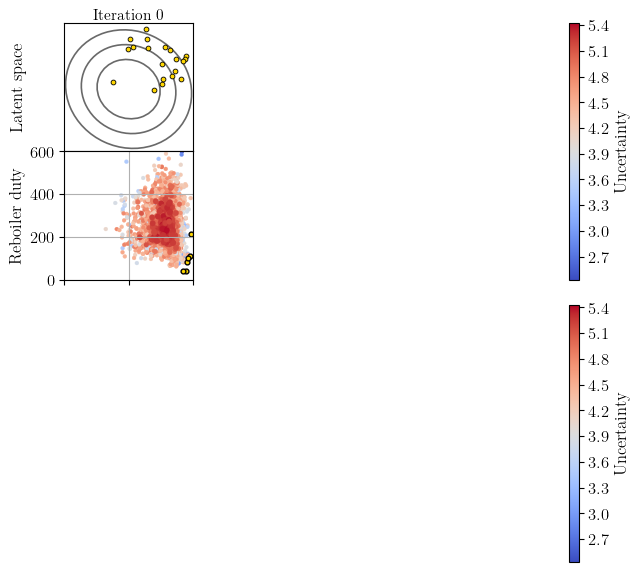

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [ ]:
import matplotlib.patches as patches
from matplotlib import colors
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from scipy.stats import multivariate_normal


# ----------------------------
# Parámetros básicos
iterations_sorted = np.array([1, 11, 21, 31, 41, 61])
cmap_name = "coolwarm"

# ----------------------------
# Figura con columna extra para colorbar
# ----------------------------
fig = plt.figure(figsize=(7, 7), constrained_layout=False)
gs = GridSpec(nrows=2, ncols=4, figure=fig,
              width_ratios=[1, 1, 1, 0.05],
              wspace=-0.05, hspace=0.10)

# Creamos una subrejilla (2 filas: [latente pequeño, real grande]) dentro de cada celda principal
latent_axes = []
real_axes = []
for r in range(2):
    for c in range(3):
        cell = gs[r, c].subgridspec(2, 1, height_ratios=[1, 1], hspace=0.0)
        ax_lat = fig.add_subplot(cell[0, 0])  # arriba: espacio latente (mini)
        ax_real = fig.add_subplot(cell[1, 0]) # abajo: espacio real (principal)
        latent_axes.append(ax_lat)
        real_axes.append(ax_real)

# Eje de colorbar ocupando ambas filas
cax_top = fig.add_subplot(gs[0, 3])  # barra para la fila superior
cax_bot = fig.add_subplot(gs[1, 3])  # barra para la fila inferior

# ----------------------------
# Normalización global del color (u = sqrt(sigma1 * sigma2))
mins, maxs = [], []
for i in iterations_sorted:
    g = np.sqrt(df1.loc[df1['iteration'] == i].iloc[:, 2] * df1.loc[df1['iteration'] == i].iloc[:, 3])
    if len(g):
        mins.append(np.nanmin(g))
        maxs.append(np.nanmax(g))
vmin = np.nanmin(mins)
vmax = np.nanmax(maxs)
norm = colors.Normalize(vmin=vmin, vmax=vmax)

# ----------------------------
# Dibujar por iteración
# ----------------------------
sc_last = None
def sample_mask(mask, frac=0.5):
    """Devuelve índices de una fracción aleatoria de un grupo"""
    idx = np.where(mask)[0]
    if len(idx) == 0:
        return np.array([], dtype=int)
    n_select = max(1, int(len(idx) * frac))  # al menos 1 si hay datos
    return rng.choice(idx, size=n_select, replace=False)

for ax_lat, ax_real, i in zip(latent_axes, real_axes, iterations_sorted):
    # ---- Filtro de datos para esta iteración
    mask = (df1['iteration'] == i)
    data = df1.loc[mask].to_numpy()
    if data.size == 0:
        # si no hay datos, ocultamos ambos ejes
        ax_lat.set_axis_off()
        ax_real.set_axis_off()
        continue

    # Ahora hay que sacar puntos no dominados y graficarlos
    F_space = data[:,:2].copy()
    F_space[:, 1] = -F_space[:, 1] # Cambiar la carga termica a positiva
    F_space[:, 0] = -F_space[:, 0] # Cambiar la composicion a negativa 
    nds = NonDominatedSorting()  
    front_indices = nds.do(F_space, only_non_dominated_front=True)
    is_pareto = np.zeros(len(data), dtype=bool)
    is_pareto[front_indices] = True
    is_dominated = ~is_pareto

    ## DataFrames resultantes
    NonDominantPoints = data[is_pareto]

    # ---- Espacio real (abajo): coloreado por u
    u = np.sqrt(data[:, 2] * data[:, 3])
    rng = np.random.default_rng(42)
    n_show = 100 
    N = len(data)
    k = min(n_show, N)

    idx = rng.choice(N, size=min(n_show, N), replace=False)
    # idx = np.argsort(u)[:k]

    p_low, p_high = np.percentile(u, [33.3, 66.6])
    mask_low  = u <= p_low
    mask_mid  = (u > p_low) & (u <= p_high)
    mask_high = u > p_high
    rng = np.random.default_rng(42)  # semilla fija para reproducibilidad
    idx_low  = sample_mask(mask_low, frac=0.40)
    idx_mid  = sample_mask(mask_mid, frac=0.05)
    idx_high = sample_mask(mask_high, frac=0.05)
    ax_real.scatter( data[idx_low, 0], -data[idx_low, 1],
        s=8, c=u[idx_low], cmap=cmap_name, norm=norm, linewidths=0.2, label="Low u"   )
    ax_real.scatter( data[idx_mid, 0], -data[idx_mid, 1],
        s=12, c=u[idx_mid], cmap=cmap_name, norm=norm, linewidths=0.2, label="Mid u"  )
    sc_last = ax_real.scatter( data[idx_high, 0], -data[idx_high, 1],
        s=16, c=u[idx_high], cmap=cmap_name, norm=norm, linewidths=0.2, label="High u" )

    ## GRAFICAR ESTOS PUNTOS PERO CON GOLD COLOR
    ax_real.scatter(NonDominantPoints[:,0], -1*NonDominantPoints[:,1],
                    s=12, facecolors='gold', edgecolors='k', linewidths=1.0)  


    ax_real.set_xlim(0, 1)
    ax_real.set_ylim(0, 600)
    ax_real.grid(True, alpha=1.0)
    ax_lat.set_box_aspect(1)  # mismo aspecto a ambas figuras
    ax_real.set_box_aspect(1) # mismo aspecto a ambas figuras
    # ---- Espacio latente (arriba): puntos globales en gris y los de la iteración resaltados
    mu  = emb_all.mean(axis=0)
    cov = np.cov(emb_all, rowvar=False)
    # regulariza por si es casi singular
    cov += 1e-6 * np.eye(2)

    eigvals, eigvecs = np.linalg.eigh(cov)
    angle_rad = np.arctan2(eigvecs[1,1], eigvecs[0,1])
    angle_deg = np.degrees(angle_rad)
    # radios 1σ y 2σ
    for k, label in zip([1.0, 1.5, 2.0], ["1$\sigma$", "1.5$\sigma$" , "2$\sigma$"]):
        width, height = 2*k*np.sqrt(eigvals)
        # angle = np.degrees(np.arctan2(eigvecs[1,1], eigvecs[0,1]))
        ell = patches.Ellipse(mu, width, height, angle=angle_deg,
                            edgecolor="0.35", facecolor="none",
                            linewidth=1.2, alpha=0.9)
        ax_lat.add_patch(ell)

    # ---- Puntos explorados en cada iteración
    mask2 = (df2['iteration'] == i)
    data2 = df2[mask2].copy()
    ax_lat.scatter(data2['t_sne1'], data2['t_sne2'],
                    s=12, facecolors='gold', edgecolors='k', linewidths=0.6)             # iteración resaltada

    ax_lat.set_title(fr"Iteration {i-1}", fontsize=11, pad=2)
    ax_lat.set_xticks([]); ax_lat.set_yticks([])
    for spine in ax_lat.spines.values():
        spine.set_alpha(1.0)

    
    prev_iters = iterations_sorted[iterations_sorted < i]
    for iprev in prev_iters:
        mask_prev = (df1['iteration'] == iprev)
        data_prev = df1.loc[mask_prev].to_numpy()
        if data_prev.size == 0:
            continue
        # Recalcular no dominados para esa iteración previa (idéntico a tu lógica)
        F_prev = data_prev[:, :2].copy()
        F_prev[:, 1] = -F_prev[:, 1]  # carga térmica positiva
        F_prev[:, 0] = -F_prev[:, 0]  # composición negativa
        nds_prev = NonDominatedSorting()
        idx_front_prev = nds_prev.do(F_prev, only_non_dominated_front=True)
        ND_prev = data_prev[idx_front_prev]

        # Plot dorado (más pequeño / con un poco de alpha para no saturar)
        ax_real.scatter(ND_prev[:, 0], -ND_prev[:, 1],
            s=10, facecolors='gold', edgecolors='k', linewidths=0.8,
            alpha=1.0, zorder=2)
        mask_prev2 = (df2['iteration'] == iprev)
        data_prev2 = df2[mask_prev2]
        if len(data_prev2) == 0:
            continue
        ax_lat.scatter(data_prev2['t_sne1'], data_prev2['t_sne2'],
            s=10, facecolors='gold', edgecolors='k', linewidths=0.6,
            alpha=1.0, zorder=2 )

# ----------------------------
# Etiquetas compartidas y limpieza de ejes
# Solo etiquetas X en la fila inferior (real_axes índices 3,4,5) y Y solo en la primera columna (0 y 3)
for j, ax in enumerate(real_axes):
    # Columna 0 (j%3==0): mostrar Y
    if (j % 3) == 0:
        ax.set_ylabel(r'Reboiler duty', fontsize=12)
    else:
        ax.set_ylabel('')
        ax.tick_params(axis='y', labelleft=False)
    # Fila superior (j<3): ocultar X
    if j < 3:
        ax.set_xlabel('')
        ax.tick_params(axis='x', labelbottom=False)
    else:
        ax.set_xlabel(r'Purity$_{\mathrm{CA}}$', fontsize=12)
latent_axes[0].set_ylabel("Latent space", fontsize=12, labelpad = 28)
latent_axes[3].set_ylabel("Latent space", fontsize=12, labelpad = 28)
# ----------------------------

mappable = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_name)
mappable.set_array([])
# Colorbar superior
cb1 = fig.colorbar(mappable, cax=cax_top, orientation="vertical")
cb1.set_label(r"Uncertainty", fontsize=12)
cb1.locator = mticker.MaxNLocator(nbins=10) #mticker.FixedLocator(metric_bar.levels)
cb1.formatter = mticker.FormatStrFormatter('%.1f')  # o '%.1f' o '%.0f'
cb1.update_ticks()

# Colorbar inferior (idéntica)
cb2 = fig.colorbar(mappable, cax=cax_bot, orientation="vertical")
cb2.set_label(r"Uncertainty", fontsize=12)
cb2.locator = mticker.MaxNLocator(nbins=10) #mticker.FixedLocator(metric_bar.levels)
cb2.formatter = mticker.FormatStrFormatter('%.1f')  # o '%.1f' o '%.0f'
cb2.update_ticks()
# Ajustes finales
fig.tight_layout()
plt.show()
# fig.savefig('case1_uncertainty.eps', format = 'eps', dpi = 300)
